<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/combining_dips/AttemptingToCombineHughesLCWithHedgesModellingV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#AHughes code begin
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 2.1MB 2.8MB/s 
     |████████████████████████████████| 6.5MB 12.2MB/s 
     |████████████████████████████████| 25.9MB 165kB/s 
     |████████████████████████████████| 256kB 43.6MB/s 
     |████████████████████████████████| 2.7MB 46.1MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp36-none-any.whl size=3831873 sha256=414d8fd96ac902d5b2893ed68ef6cdfd3e937a87c40bdd00f02e5928a03e8901
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=2fc75bd67eea438855be62904bd6c5d08a1ce2550d772191a9fab996dac06fd2
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=58b1d4a1b8289a8e59b858031270313f34f6573e1d2fe7338bd8ae68c5a63f03
  Stored in directory: /root/.cache/pip/wheels

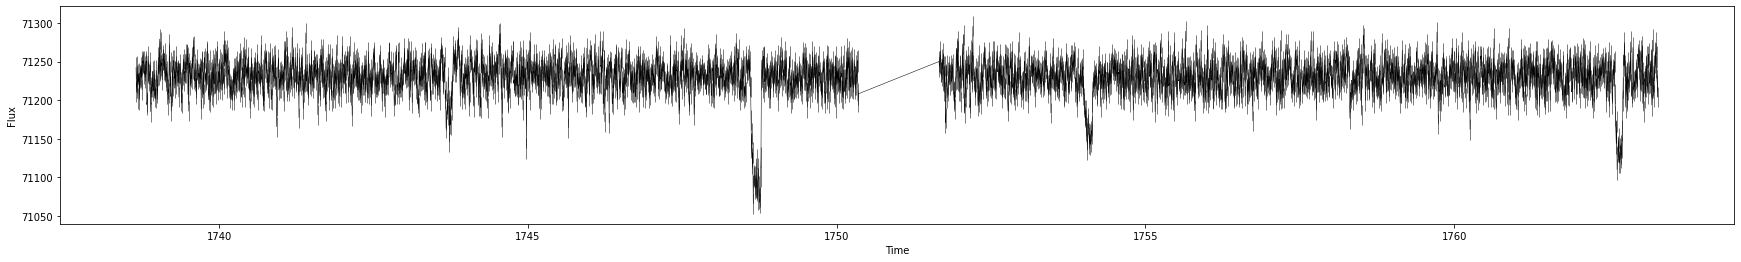

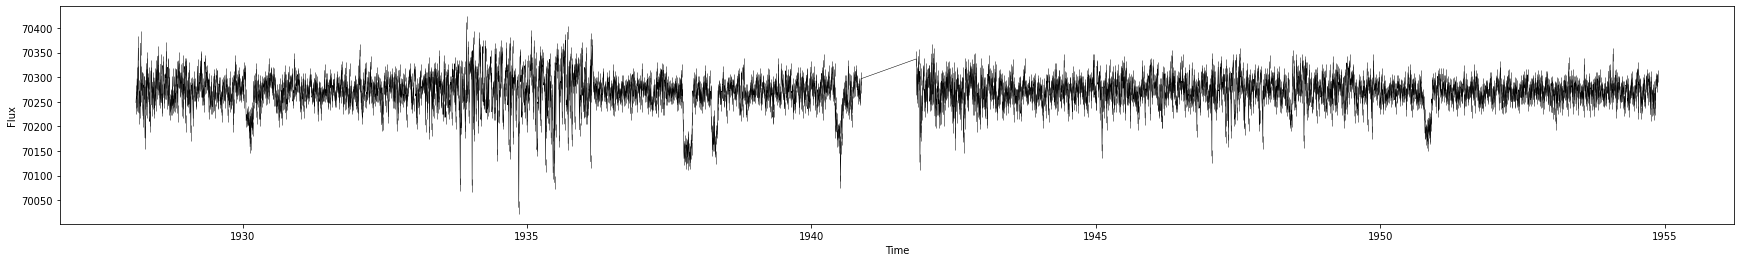

In [ ]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
%matplotlib inline

flags = lk.utils.TessQualityFlags
q = flags.CoarsePoint | flags.Desat | flags.Argabrightening

tpfs = lk.search_targetpixelfile("TIC 27491137").download_all(quality_bitmask=q)

clcs = []
for tpf in tpfs:
    breaks = np.where(np.append(False, np.diff(tpf.time) > (np.median(np.diff(tpf.time)) * 5)))[0]
    aper = tpf.create_threshold_mask()


    lc = tpf.to_lightcurve()

    # Scattered light
    bkg = tpf.get_bkg_lightcurve(tpf.pipeline_mask)
    bkg[~np.isfinite(lc.flux_err)].flux *= 0
    lc += bkg
    lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

    bkg = tpf.flux_bkg
    bkg[~np.isfinite(bkg)] = 0
    pixels = (tpf.flux + bkg)[:, ~aper]
    dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).split(list(breaks)).append_constant()

    # Pos corr
    ts = np.vstack([((tpf.time - t[0])/(t[-1] - t[0]) - 0.5) * np.in1d(tpf.time, t) for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p1 = np.vstack([np.nan_to_num(tpf.pos_corr1) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p2 = np.vstack([np.nan_to_num(tpf.pos_corr2) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    pdm = lk.DesignMatrix(np.hstack([ts, ts**2, p1, p2, p1*p2, p1**2*p2, p1*p2**2, p1**2*p2**2]), name = 'poscorrs')
    pdm.prior_sigma = np.ones(pdm.shape[1]) * 0.01


    spline = lk.designmatrix.create_spline_matrix(lc.time, n_knots=80)

    dm = lk.DesignMatrixCollection([dm1, pdm, spline])

    # First iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10)

    # YOU SHOULD REPLACE THIS HACKY MASK WITH A BETTER ONE.
    a = (clean_lc).bin(10).flatten(81)
    _, m = a.remove_outliers(2, return_mask=True)
    m = (convolve(m, Box1DKernel(10)) > 0.5)
    mask = np.interp(clean_lc.time, a.time, m) > 0
    mask = convolve(mask, Box1DKernel(5)) > 0

    # second iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10, cadence_mask=~mask)

    clean_lc = lk.LightCurve(np.asarray(clean_lc.time, np.float64),
                         np.asarray(clean_lc.flux, np.float64),
                         np.asarray(clean_lc.flux_err, np.float64))

    fig, ax = plt.subplots(figsize=(30, 4))
    (clean_lc).bin(5, method='median').errorbar(ls='-', ax=ax, c='k')
    
    clcs.append(clean_lc.normalize())

In [ ]:
clc = lk.LightCurveCollection(clcs).stitch()

/usr/local/lib/python3.6/dist-packages/lightkurve/lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


(1935.0, 1940.0)

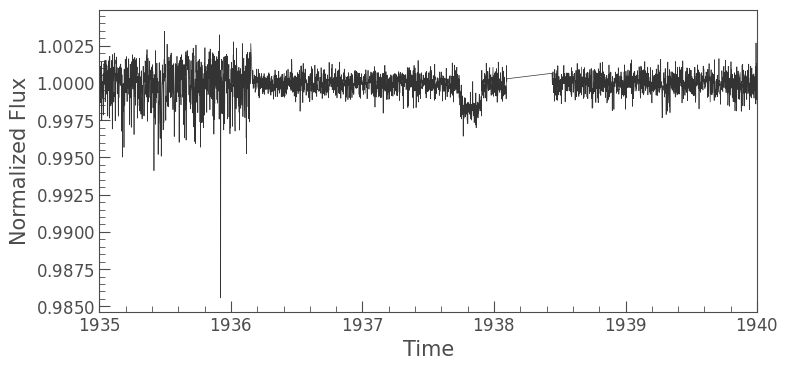

In [ ]:
mask1 = (clc.time < 1761) | (clc.time > 1764) 
m1lc = clc[mask1]
mask2 = (m1lc.time < 1938.1)| (m1lc.time > 1938.44) 
lc =  m1lc[mask2]
lc.plot()
plt.xlim(1935, 1940)
#AHughes code end

In [ ]:
len(lc)

33453

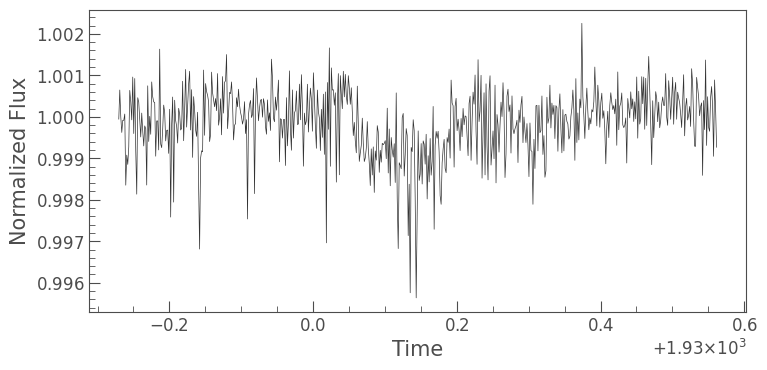

In [ ]:
dip5 = lc[16300:16900]
dip5.plot()

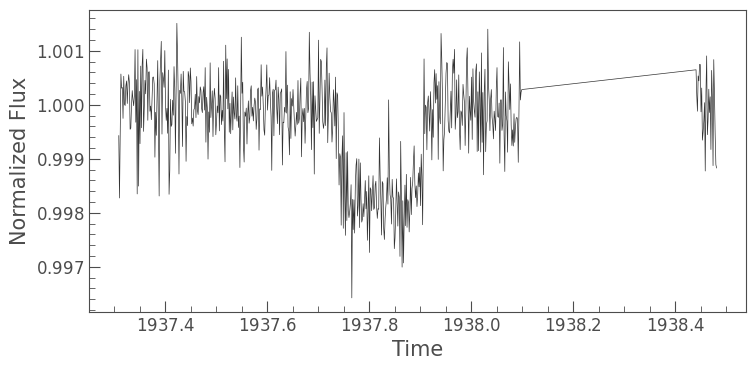

In [ ]:
dip6 = lc[21750:22350]
dip6.plot()

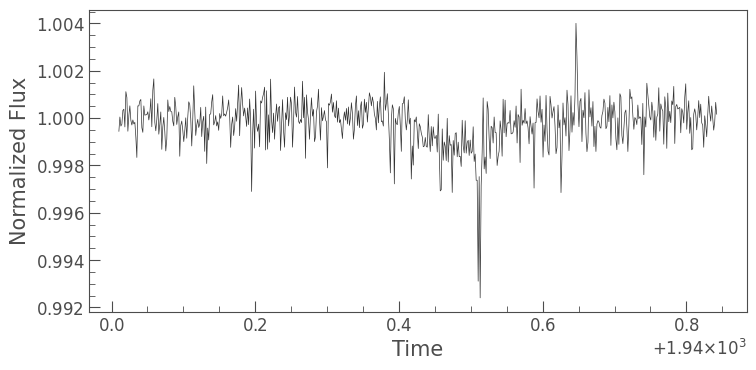

In [ ]:
dip8 = lc[23450:24050]
dip8.plot()

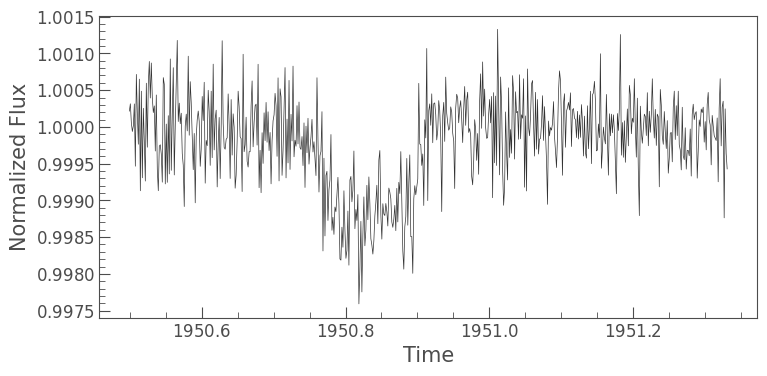

In [ ]:
dip9 = lc[30300:30900]
dip9.plot()

In [ ]:
#CHedges code for fitting data
#Need to make maskes for every dip I assume?
import theano.tensor as tt
masks = [tt.as_tensor(np.in1d(np.arange(len(lc.flux)), np.arange(a, b)).astype(float)) for a, b in zip([3000, 6700, 9500, 15650, 16300, 21750, 23450, 30300], [4200, 7688, 10800, 16812, 16900, 22350, 24050, 30900])]

In [ ]:
#I have found the t values of the s23 dips and added them to the masks array. I will then create more light curves below for these dips.

In [ ]:
dips = [(lc/mask.eval())[np.isfinite(1/mask.eval())] for mask in masks]

In [ ]:
import pymc3 as pm
import exoplanet as xo
from exoplanet.gp import terms, GP
with pm.Model() as model:
    mean = pm.Normal("mean", mu=1, sd=0.01)

    log_sigma = pm.Uniform("log_sigma", lower=-10, upper=10)
    log_rho = pm.Uniform("log_rho", lower=-10, upper=10)

    # Set up the kernel an GP
    kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)
    gp = GP(kernel, lc.time, lc.flux_err ** 2)
    


    # Stellar variables
    r_star = pm.Normal("r_star", mu=0.772148, sd=0.0454673, testval=0.78)    
    m_star = pm.Normal("m_star", mu=0.87, sd=0.108032, testval=0.87)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    #Uranus sized candidate
    tv = 1748.69 
    t01 = pm.Uniform("t01", lower=tv-0.1, upper=tv+0.1)
    period1 = pm.Uniform("period1", lower=0, upper=200, testval=189.1)
    r1 = pm.Uniform("r1", lower=0.001, upper=0.1, testval=0.04)
    b1 = xo.distributions.ImpactParameter("b1", ror=r1/r_star)
    orbit1 = xo.orbits.KeplerianOrbit(period=period1, t0=t01, b=b1, r_star=r_star, m_star=m_star) 
    light_curve1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit1, r=r1, t=lc.time)[:, 0]

    #Super Earth candidate 1
    tv = 1743.72
    t02 = pm.Uniform("t02", lower=tv-0.1, upper=tv+0.1)
    period2 = pm.Uniform("period2", lower=1, upper=14, testval=10.4)
    r2 = pm.Uniform("r2", lower=0.001, upper=0.1, testval=0.04)
    b2 = xo.distributions.ImpactParameter("b2", ror=r2/r_star)
    orbit2 = xo.orbits.KeplerianOrbit(period=period2, t0=t02, b=b2, r_star=r_star, m_star=m_star) 
    light_curve2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit2, r=r2, t=lc.time)[:, 0] 

    #I swapped round the uranus and super earth as in Christina's code she did the uranus, t~1748, first.



    #Spare transit setup, not required for the first runthrough but will be needed for the second super earth so kept for easy copy pasta

    #tv =  1762.67
    #t03 = pm.Uniform("t03", lower=tv-0.1, upper=tv+0.1)
    #period3 = pm.Uniform("period3", lower=0, upper=200, testval=30)
    #r3 = pm.Uniform("r3", lower=0.001, upper=0.1, testval=0.04)
    #b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star)
    #orbit3 = xo.orbits.KeplerianOrbit(period=period3, t0=t03, b=b2, r_star=r_star, m_star=m_star) 
    #light_curve3 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit3, r=r3, t=lc.time)[:, 0] * masks[2]


    #Model light curve
    light_curve = pm.Deterministic('light_curve', light_curve1 + light_curve2 + mean)
    
    
#s    pm.Normal("obs1", mu=light_curve, sd=clean_lc.flux_err, observed=clean_lc.flux)
    
#     # Fit for the maximum a posteriori parameters given the simuated dataset
#     # Posterior distribution is usually given as Prior*Likelihood


    # Condition the GP on the observations and add the marginal likelihood
    # to the model
    gp.marginal("gp", observed=lc.flux - light_curve)

    gp_pred = pm.Deterministic('gp_pred', gp.predict())


    
    map_soln = xo.optimize(start=model.test_point, vars=[log_sigma, log_rho])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, mean])
    map_soln = xo.optimize(start=map_soln, vars=[r1, r2])
    map_soln = xo.optimize(start=map_soln, vars=[period1])
    map_soln = xo.optimize(start=map_soln, vars=[t01, t02, mean, r1, r2, period1, b1, b2, log_sigma, log_rho])

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [log_rho, log_sigma]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

optimizing logp for variables: [mean, t02, t01]


message: Optimization terminated successfully.
logp: 194434.2965302333 -> 194472.38097678314
optimizing logp for variables: [r2, r1]


message: Optimization terminated successfully.
logp: 194472.38097678314 -> 196155.11760177606
optimizing logp for variables: [period1]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 196155.11760177606 -> 196155.26276247457


optimizing logp for variables: [log_rho, log_sigma, b2, r2, r_star, b1, r1, period1, mean, t02, t01]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wil

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 196155.26276247457 -> 196882.6785540184


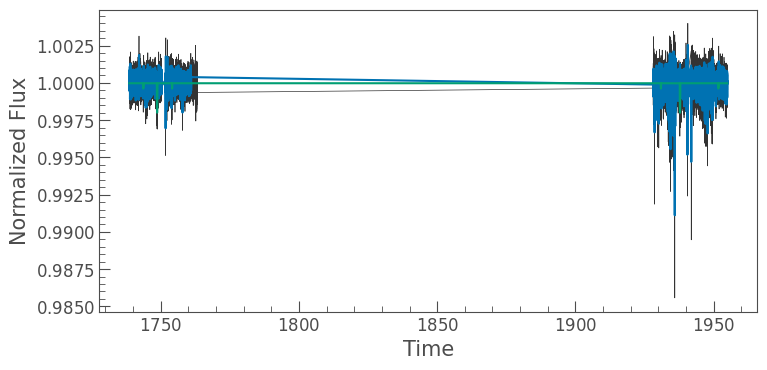

In [ ]:
clc.plot()
plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'])
plt.plot(lc.time, map_soln['light_curve'])

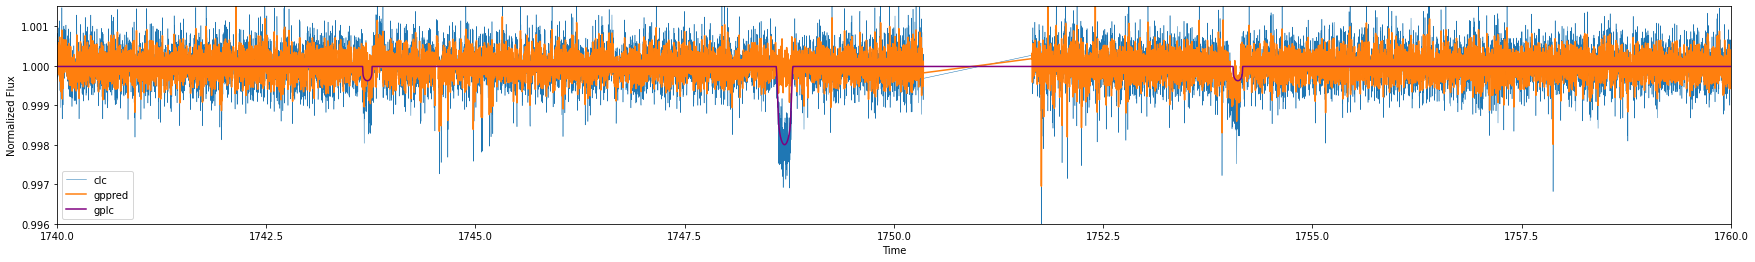

In [ ]:
fig, ax = plt.subplots(figsize=(30, 4))
clc.plot(ax=ax, label='clc')
plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'], label='gppred')
plt.plot(lc.time, map_soln['light_curve'], label='gplc', color='purple')
plt.xlim(1740, 1760)
plt.ylim(0.9960, 1.0015)
plt.legend()

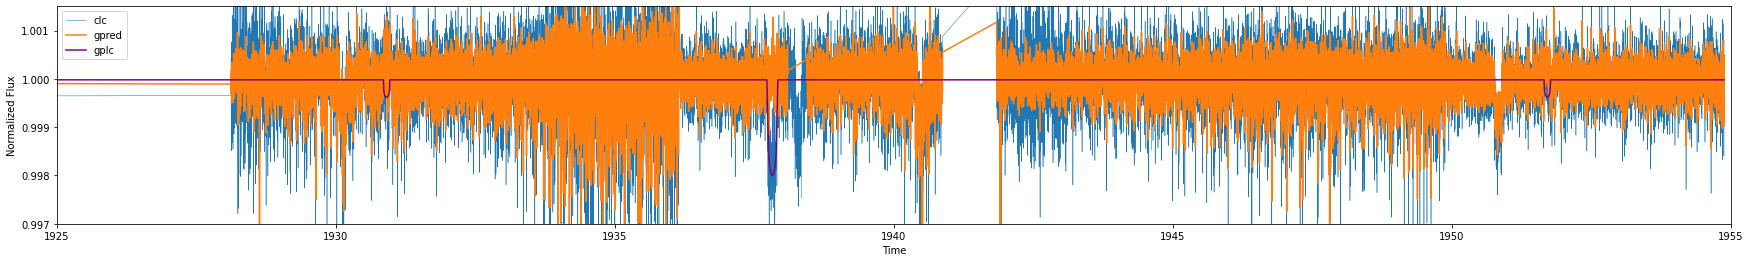

In [ ]:
fig, ax = plt.subplots(figsize=(30, 4))
clc.plot(ax=ax, label='clc')
plt.plot(lc.time, map_soln['gp_pred'] + map_soln['mean'], label='gpred')
plt.plot(lc.time, map_soln['light_curve'], label='gplc', color='purple')
plt.xlim(1925, 1955)
plt.ylim(0.9970, 1.0015)
plt.legend()

In [ ]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=2000,
        start=map_soln,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [b2, r2, period2, t02, b1, r1, period1, t01, u, m_star, r_star, log_rho, log_sigma, mean]
Sampling chain 0, 0 divergences:   0%|          | 12/3000 [00:29<2:57:25,  3.56s/it]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:   0%|          | 12/3000 [00:32<2:16:56,  2.75s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks
